<a href="https://colab.research.google.com/github/pouya-mhb/DS-ML-DL-Practices/blob/main/Ensemble_Learning_on_6Labled_Emo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# XGBoost classifier
import xgboost as xgb

In [5]:

# Load the dataset
df = pd.read_csv('emotions.csv')


In [6]:

# Basic EDA
print("First 5 rows of the dataset:")
print(df.head())

print("\nDataset information:")
print(df.info())

print("\nStatistical summary:")
print(df.describe())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

First 5 rows of the dataset:
   Mean_Acc1298_Mean_Mem40_Centroid  Mean_Acc1298_Mean_Mem40_Rolloff  \
0                          0.034741                         0.089665   
1                          0.081374                         0.272747   
2                          0.110545                         0.273567   
3                          0.042481                         0.199281   
4                          0.074550                         0.140880   

   Mean_Acc1298_Mean_Mem40_Flux  Mean_Acc1298_Mean_Mem40_MFCC_0  \
0                      0.091225                      -73.302422   
1                      0.085733                      -62.584437   
2                      0.084410                      -65.235325   
3                      0.093447                      -80.305152   
4                      0.079789                      -93.697749   

   Mean_Acc1298_Mean_Mem40_MFCC_1  Mean_Acc1298_Mean_Mem40_MFCC_2  \
0                        6.215179                        0.615074 

In [7]:
X = df.drop(columns=df.columns[-6:])
y = df[df.columns[-6:]]

In [8]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:

# Scale features (recommended for many classifiers)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:

# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)


In [11]:

# Optional: Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2]
}


In [12]:

grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found:", grid_search.best_params_)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:03:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


In [13]:

# Use the best estimator from grid search
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:03:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


Test Accuracy: 26.89%

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        36
           1       0.50      0.33      0.40        33
           2       0.68      0.83      0.75        53
           3       0.81      0.91      0.86        23
           4       0.76      0.61      0.68        31
           5       0.82      0.66      0.73        41

   micro avg       0.70      0.65      0.67       217
   macro avg       0.70      0.64      0.66       217
weighted avg       0.70      0.65      0.66       217
 samples avg       0.67      0.66      0.63       217



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


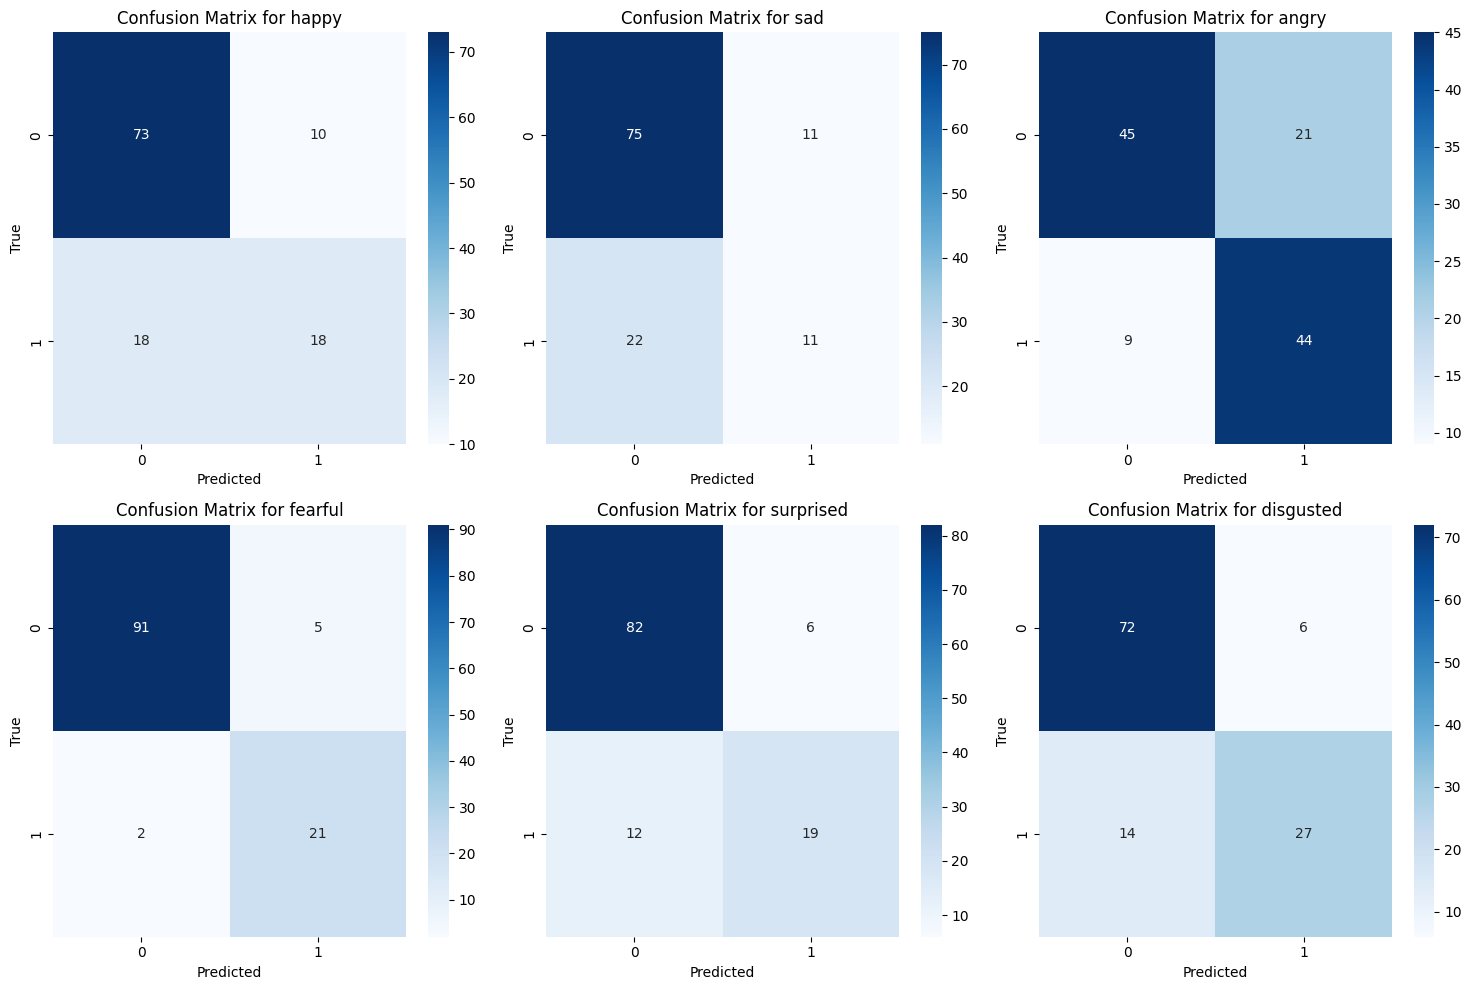

In [17]:
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix

# Evaluate the model on the test set
y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

cm = multilabel_confusion_matrix(y_test, y_pred)

# Print accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Plotting the confusion matrices
labels = ['happy', 'sad', 'angry', 'fearful', 'surprised', 'disgusted']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (label, matrix) in enumerate(zip(labels, cm)):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {label}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

# Ensemble Learning

In [21]:
# Define base classifiers for the ensemble
clf1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = LogisticRegression(max_iter=1000, random_state=42)


In [25]:
from sklearn.multioutput import ClassifierChain, MultiOutputClassifier
# ensemble_clf = ClassifierChain(xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), order='random', random_state=42)

# Create a VotingClassifier ensemble (soft voting averages predicted probabilities)
ensemble_clf = MultiOutputClassifier(VotingClassifier(
    estimators=[('xgb', clf1), ('rf', clf2), ('lr', clf3)],
    voting='soft',
    n_jobs=-1
))


In [26]:

# Train the ensemble model
ensemble_clf.fit(X_train_scaled, y_train)


MultiOutputClassifier(estimator=VotingClassifier(estimators=[('xgb',
                                                              XGBClassifier(base_score=None,
                                                                            booster=None,
                                                                            callbacks=None,
                                                                            colsample_bylevel=None,
                                                                            colsample_bynode=None,
                                                                            colsample_bytree=None,
                                                                            device=None,
                                                                            early_stopping_rounds=None,
                                                                            enable_categorical=False,
                                                                            eval_metric='mlogloss',
                                                                            feature_types=None,
                                                                            gamma=None,
                                                                            grow_policy=None,
                                                                            importance_type=None,
                                                                            in...
                                                                            max_cat_to_onehot=None,
                                                                            max_delta_step=None,
                                                                            max_depth=None,
                                                                            max_leaves=None,
                                                                            min_child_weight=None,
                                                                            missing=nan,
                                                                            monotone_constraints=None,
                                                                            multi_strategy=None,
                                                                            n_estimators=None,
                                                                            n_jobs=None,
                                                                            num_parallel_tree=None,
                                                                            random_state=42, ...)),
                                                             ('rf',
                                                              RandomForestClassifier(random_state=42)),
                                                             ('lr',
                                                              LogisticRegression(max_iter=1000,
                                                                                 random_state=42))],
                                                 n_jobs=-1, voting='soft'))

Ensemble Model Test Accuracy: 36.13%

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.56      0.61        36
           1       0.56      0.27      0.37        33
           2       0.75      0.87      0.81        53
           3       0.81      0.96      0.88        23
           4       0.81      0.55      0.65        31
           5       0.79      0.63      0.70        41

   micro avg       0.74      0.65      0.69       217
   macro avg       0.73      0.64      0.67       217
weighted avg       0.73      0.65      0.67       217
 samples avg       0.71      0.66      0.65       217



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


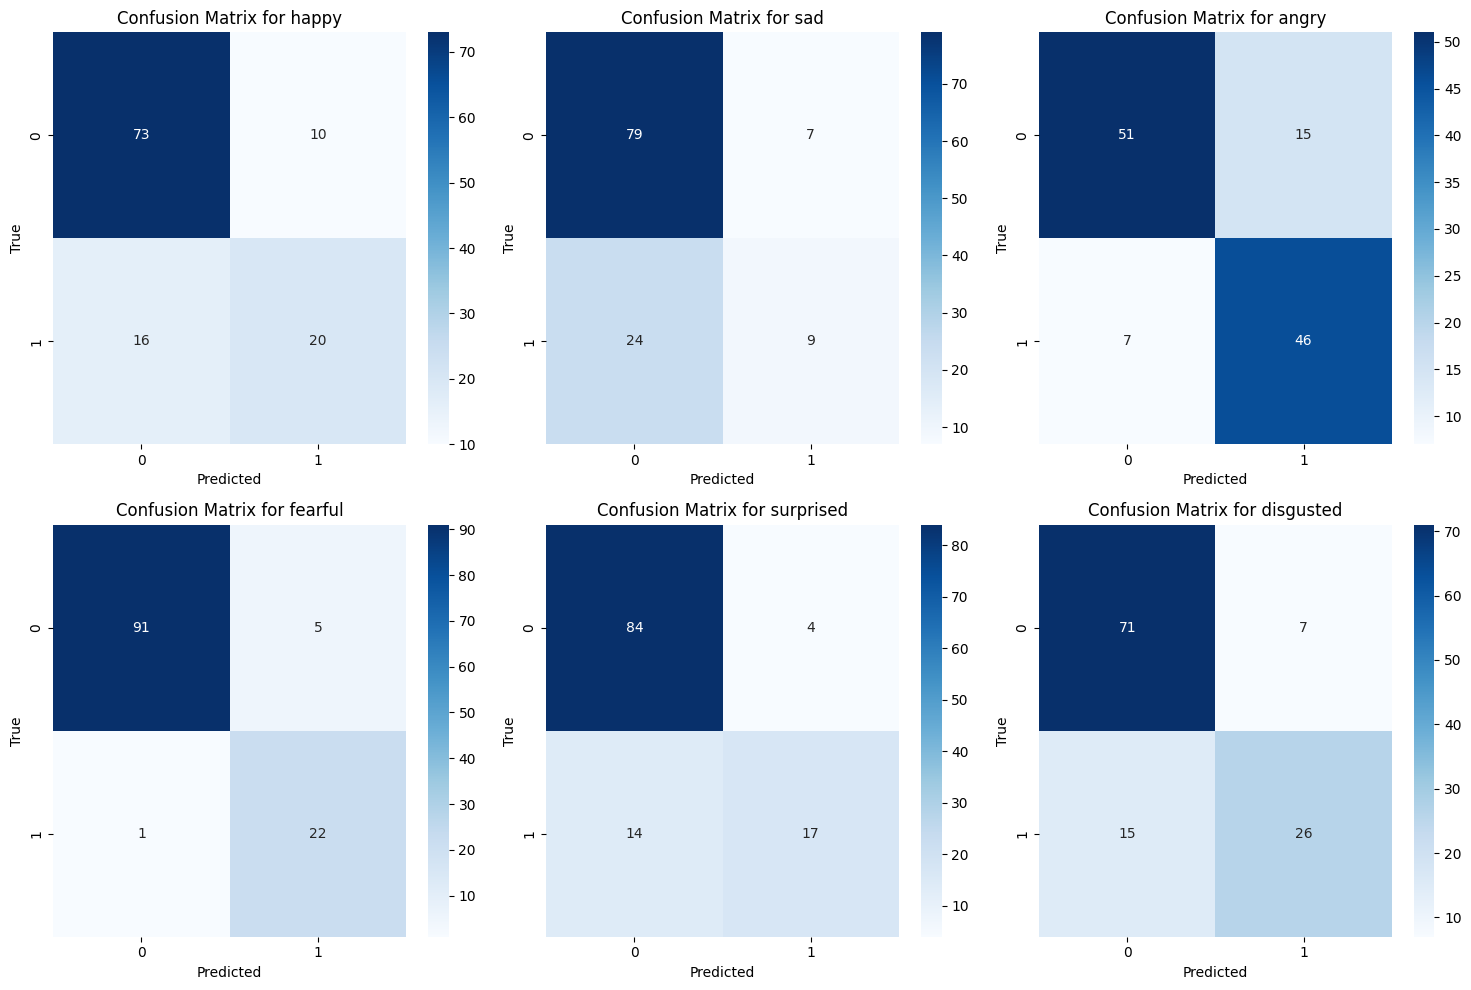

In [29]:
# Evaluate the model on the test set
y_pred = ensemble_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Model Test Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot individual confusion matrices for each emotion
cm = multilabel_confusion_matrix(y_test, y_pred)
labels = ['happy', 'sad', 'angry', 'fearful', 'surprised', 'disgusted']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (label, matrix) in enumerate(zip(labels, cm)):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for {label}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()